# **Numerical**: Implementation of 4 Methods


---

## First Method: **ISODA method**(From BOOK)


 ncase =  1 

       t       In        G        I
    0.00        0    81.14    5.671
    0.25        0    81.14    5.671
    0.50        0    81.14    5.671
    0.75        0    81.14    5.671
    1.00        0    81.14    5.671
       .        .        .        .
       .        .        .        .
       .        .        .        .
Output for t = 1.25 to 10.75 removed
       .        .        .        .
       .        .        .        .
       .        .        .        .
   11.00        0    81.14    5.671
   11.25        0    81.14    5.671
   11.50        0    81.14    5.671
   11.75        0    81.14    5.671
   12.00        0    81.14    5.671



 ncase =  2 

       t       In        G        I
    0.00    80000    81.14    5.671
    0.25    80000   201.71    7.100
    0.50    80000   286.72   10.687
    0.75        0   220.56   13.975
    1.00        0   161.74   15.405
       .        .        .        .
       .        .        .        .
       .        .        .     

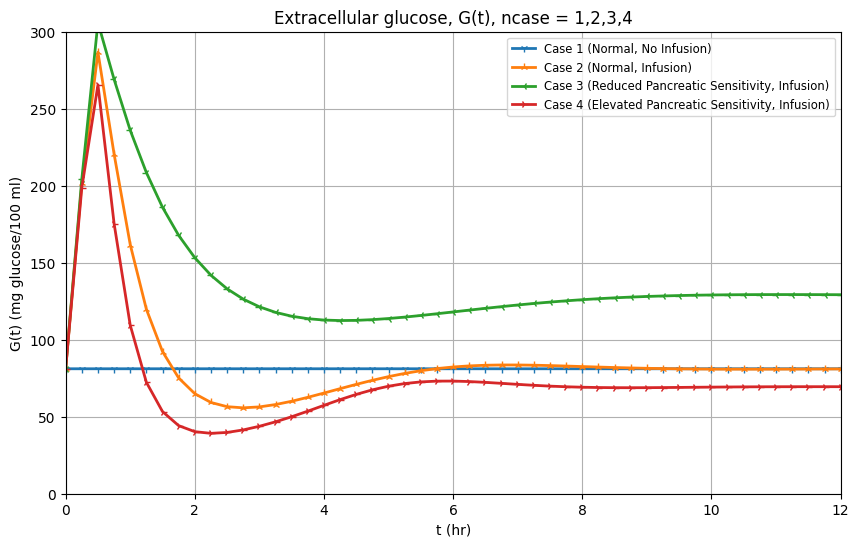

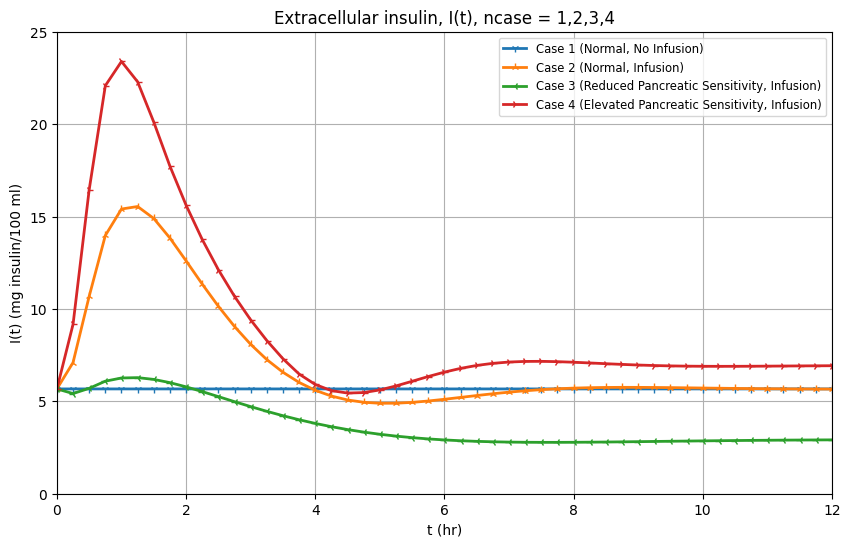

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------
# ODE routine: glucose_insulin_ode
# This function defines the system of differential equations (dG/dt and dI/dt).
# It takes time (t), state variables (y), and parameters (params) as input.
# y[0] is Glucose (G), y[1] is Insulin (I)
# --------------------------------------------------------------------------
def glucose_insulin_ode(t, y, params):
    # Assign state variables
    G = y[0]
    I = y[1]

    # Extract parameters from the dictionary
    Cg = params['Cg']
    Ci = params['Ci']
    Q = params['Q']
    Dd = params['Dd']
    Gg = params['Gg']
    Gk = params['Gk']
    Mu = params['Mu']
    G0 = params['G0']
    Aa = params['Aa']
    Bb = params['Bb'] # Bb is case-specific, passed via params
    Gt = params['Gt'] # Gt is case-specific, passed via params

    # Glucose infusion function (In)
    if 0 <= t <= 0.51: # Note: Document uses 0.51 to avoid floating point issues with t=0.5
        In = Gt
    else:
        In = 0

    # Glucose equations (Eqs. 2.1b and 2.1c)
    if G < Gk:
        dGdt = (1 / Cg) * (Q + In - (Gg * I * G) - Dd * G)
    else: # G >= Gk
        dGdt = (1 / Cg) * (Q + In - (Gg * I * G) - Dd * G - Mu * (G - Gk))

    # Insulin equations (Eqs. 2.2b and 2.2c)
    if G < G0:
        dIdt = (1 / Ci) * (-Aa * I)
    else: # G >= G0
        dIdt = (1 / Ci) * (-Aa * I + Bb * (G - G0))

    # Return derivative vector
    return [dGdt, dIdt]

# --------------------------------------------------------------------------
# Main program
# This section sets up parameters, runs the simulation, and handles output.
# --------------------------------------------------------------------------

# Vectors and matrices for graphical output
nout = 49 # Number of output points
Gplot = np.zeros((nout, 4))
Iplot = np.zeros((nout, 4))
tplot = np.zeros(nout)

# Define fixed model parameters (from document page 90)
fixed_params = {
    'Ex': 15000, # extracellular space (ml)
    'Cg': 150,   # glucose capacitance = Ex/100 (ml)
    'Ci': 150,   # insulin capacitance = Ex/100 (ml)
    'Q': 8400,   # liver release of glucose (mG/hr)
    'Dd': 24.7,  # first-order glucose loss (mG/hr/mGml)
    'Gg': 13.9,  # controlled glucose loss (mG/hr/mGml/mIml)
    'Gk': 250,   # renal threshold (mGml)
    'Mu': 72,    # renal loss rate (mG/hr/mGml)
    'G0': 51,    # pancreas threshold (mGml)
    'Aa': 76     # first-order insulin rate (mI/hr/mGml)
}

# Step through four cases
for ncase in range(1, 5): # Python range is exclusive of end, so 1 to 4

    # Create a mutable dictionary for current case parameters
    current_params = fixed_params.copy()

    # Select the case-specific parameters (Bb and Gt)
    if ncase == 1:
        current_params['Bb'] = 14.3
        current_params['Gt'] = 0 # No glucose infusion
    elif ncase == 2:
        current_params['Bb'] = 14.3
        current_params['Gt'] = 80000 # With glucose infusion
    elif ncase == 3:
        current_params['Bb'] = 0.2 * 14.3 # Reduced pancreatic sensitivity
        current_params['Gt'] = 80000 # With glucose infusion
    elif ncase == 4:
        current_params['Bb'] = 2.0 * 14.3 # Elevated pancreatic sensitivity
        current_params['Gt'] = 80000 # With glucose infusion

    # Initial conditions (page 90)
    yini = [81.14, 5.671] # G(t=0) and I(t=0)

    # Time interval (page 90)
    t_span = (0, 12) # Start and end time for integration
    times = np.linspace(t_span[0], t_span[1], nout) # Specific time points for output

    # --- MODIFIED LSODA CALL WITH EXPLICIT TOLERANCES ---
    # ODE integration using solve_ivp with method='LSODA'
    # 'args' passes the current_params dictionary to the ODE function
    sol = solve_ivp(
        fun=glucose_insulin_ode,
        t_span=t_span,
        y0=yini,
        method='LSODA',
        t_eval=times,
        args=(current_params,), # Pass parameters as a tuple
        rtol=1e-6, # Set relative tolerance to match R's common default
        atol=1e-6  # Set absolute tolerance to match R's common default
    )
    # ----------------------------------------------------------

    # Extract results
    out_t = sol.t
    out_G = sol.y[0]
    out_I = sol.y[1]

    # ODE numerical solution output (Table 2.1 style)
    print(f"\n ncase = {ncase:2d} \n")
    print(f"{'t':>8} {'In':>8} {'G':>8} {'I':>8}") # Table header

    # Print first few rows (as in document's Table 2.1)
    for it in range(nout):
        t_current = out_t[it]
        # Recalculate In for printing, as it's time-dependent
        if 0 <= t_current <= 0.51:
            In_print = current_params['Gt']
        else:
            In_print = 0

        # Only print first few and last few rows to mimic "abbreviated output"
        if it <= 4 or it >= (nout - 5): # Python indexing is 0-based, so it <= 4 for first 5
            print(f"{out_t[it]:>8.2f} {In_print:>8.0f} {out_G[it]:>8.2f} {out_I[it]:>8.3f}")
        elif it == 5: # Add ellipsis for removed rows (corresponds to R's it == 6)
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print("Output for t = 1.25 to 10.75 removed")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
    print("\n") # Newline after each table

    # Store solution for plotting
    Gplot[:, ncase-1] = out_G # Python uses 0-based indexing for columns
    Iplot[:, ncase-1] = out_I
    if ncase == 1:
        tplot = out_t # Time values (only need to store once)

# --------------------------------------------------------------------------
# Plotting (Figures 2.1 and 2.2 style)
# --------------------------------------------------------------------------

# Set up plot labels and titles
plot_labels = [
    "Case 1 (Normal, No Infusion)",
    "Case 2 (Normal, Infusion)",
    "Case 3 (Reduced Pancreatic Sensitivity, Infusion)",
    "Case 4 (Elevated Pancreatic Sensitivity, Infusion)"
]
plot_markers = ['1', '2', '3', '4'] # Using string markers for consistency with R's pch

# Single plot for Glucose (G)
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability
for i in range(4):
    plt.plot(tplot, Gplot[:, i], marker=plot_markers[i], linestyle='-', linewidth=2, label=plot_labels[i])

plt.xlabel("t (hr)")
plt.ylabel("G(t) (mg glucose/100 ml)")
plt.xlim(0, 12)
plt.ylim(0, 300)
plt.title("Extracellular glucose, G(t), ncase = 1,2,3,4")
plt.legend(loc="upper right", fontsize='small')
plt.grid(True)
plt.show()

# Single plot for Insulin (I)
plt.figure(figsize=(10, 6)) # Adjust figure size
for i in range(4):
    plt.plot(tplot, Iplot[:, i], marker=plot_markers[i], linestyle='-', linewidth=2, label=plot_labels[i])

plt.xlabel("t (hr)")
plt.ylabel("I(t) (mg insulin/100 ml)")
plt.xlim(0, 12)
plt.ylim(0, 25)
plt.title("Extracellular insulin, I(t), ncase = 1,2,3,4")
plt.legend(loc="upper right", fontsize='small')
plt.grid(True)
plt.show()


## Second Method: **Newton-Raphson with Backward Euler**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. Glucose-Insulin ODE Model
# ---------------------------
def glucose_model(t, y, Bb, Gt):
    G, I = y
    In = Gt if (0 <= t <= 0.5) else 0  # Glucose infusion for first 0.5 hr

    # Model parameters
    Ex, Cg, Ci = 15000, 150, 150
    Q, Dd, Gg = 8400, 24.7, 13.9
    Gk, Mu, G0 = 250, 72, 51
    Aa = 76

    # dG/dt
    dGdt = (1 / Cg) * (Q + In - Gg * I * G - Dd * G)
    if G >= Gk:
        dGdt -= (1 / Cg) * (Mu * (G - Gk))

    # dI/dt
    dIdt = (1 / Ci) * (-Aa * I)
    if G >= G0:
        dIdt += (1 / Ci) * (Bb * (G - G0))

    return np.array([dGdt, dIdt])

# ---------------------------
# 2. Numerical Jacobian (for Newton-Raphson)
# ---------------------------
def numerical_jacobian(f, t, y, h, params, eps=1e-8):
    n = len(y)
    J = np.zeros((n, n))
    f0 = f(t, y, *params)
    for i in range(n):
        y_eps = y.copy()
        y_eps[i] += eps
        fi = f(t, y_eps, *params)
        J[:, i] = (fi - f0) / eps
    return J

# ---------------------------
# 3. Backward Euler using Newton-Raphson
# ---------------------------
def backward_euler_newton(f, t, y, h, params, tol=1e-6, max_iter=50):
    y_new = y.copy()
    for i in range(max_iter):
        F = y_new - y - h * f(t + h, y_new, *params)
        J = np.eye(len(y)) - h * numerical_jacobian(f, t + h, y_new, h, params)
        delta = np.linalg.solve(J, -F)
        y_new += delta
        if np.linalg.norm(delta) < tol:
            break
    else:
        print("⚠️ Warning: Newton-Raphson did not converge at time t =", t)
    return y_new

# ---------------------------
# 4. Main Solver (Backward Euler with output similar to ISODA)
# ---------------------------
def solve_glucose_insulin_backward_euler(t_end=12, dt=0.25):
    nout = int(t_end / dt) + 1
    times = np.linspace(0, t_end, nout)

    Gplot = np.zeros((nout, 4))
    Iplot = np.zeros((nout, 4))

    # Define fixed model parameters
    fixed_params = {
        'Ex': 15000, 'Cg': 150, 'Ci': 150,
        'Q': 8400, 'Dd': 24.7, 'Gg': 13.9,
        'Gk': 250, 'Mu': 72, 'G0': 51, 'Aa': 76
    }

    cases = [
        {'Bb': 14.3, 'Gt': 0, 'label': 'Case 1'},
        {'Bb': 14.3, 'Gt': 80000, 'label': 'Case 2'},
        {'Bb': 0.2 * 14.3, 'Gt': 80000, 'label': 'Case 3'},
        {'Bb': 2.0 * 14.3, 'Gt': 80000, 'label': 'Case 4'}
    ]

    for ncase in range(4):
        params = (cases[ncase]['Bb'], cases[ncase]['Gt'])
        y = np.array([81.14, 5.671])  # Initial condition: [G0, I0]

        print(f"\n ncase = {ncase + 1} ({cases[ncase]['label']})\n")
        print(f"{'t':>8} {'In':>8} {'G':>8} {'I':>8}")

        for i, t in enumerate(times):
            In = params[1] if 0 <= t <= 0.5 else 0
            if i <= 4 or i >= nout - 5:  # print first 5 and last 5 points
                print(f"{t:8.2f} {In:8.0f} {y[0]:8.2f} {y[1]:8.3f}")
            elif i == 5:
                print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
                print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
                print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
                print("Output for t = 1.25 to 10.75 removed")
                print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
                print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")

            # 10 substeps to match accuracy
            for _ in range(10):
                y = backward_euler_newton(glucose_model, t, y, dt / 10, params)

            Gplot[i, ncase] = y[0]
            Iplot[i, ncase] = y[1]

    return times, Gplot, Iplot

# ---------------------------
# 5. Plotting Results
# ---------------------------
def plot_results(times, Gplot, Iplot):
    labels = [
        "Case 1 (Baseline, No Infusion)",
        "Case 2 (Normal, Infusion)",
        "Case 3 (Reduced Bb, Infusion)",
        "Case 4 (Enhanced Bb, Infusion)"
    ]
    markers = ['1', '2', '3', '4']

    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.plot(times, Gplot[:, i], marker=markers[i], label=labels[i], linewidth=2)
    plt.xlabel("t (hr)")
    plt.ylabel("G(t) (mg glucose/100 ml)")
    plt.xlim(0, 12)
    plt.ylim(0, 300)
    plt.title("Extracellular Glucose G(t) - Backward Euler")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.plot(times, Iplot[:, i], marker=markers[i], label=labels[i], linewidth=2)
    plt.xlabel("t (hr)")
    plt.ylabel("I(t) (mg insulin/100 ml)")
    plt.xlim(0, 12)
    plt.ylim(0, 25)
    plt.title("Extracellular Insulin I(t) - Backward Euler")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# 6. Main Execution
# ---------------------------
if __name__ == "__main__":
    print("Running Backward Euler (Newton-Raphson)...\n")
    times, Gplot, Iplot = solve_glucose_insulin_backward_euler()
    plot_results(times, Gplot, Iplot)


## Third method : Trapezoidal Method


 ncase =  1 

       t       In        G        I
    0.00        0    81.14    5.671
    0.25        0    81.14    5.671
    0.50        0    81.14    5.671
    0.75        0    81.14    5.671
    1.00        0    81.14    5.671
       .        .        .        .
       .        .        .        .
       .        .        .        .
Output for t = 1.25 to 10.75 removed
       .        .        .        .
       .        .        .        .
       .        .        .        .
   11.00        0    81.14    5.671
   11.25        0    81.14    5.671
   11.50        0    81.14    5.671
   11.75        0    81.14    5.671
   12.00        0    81.14    5.671


ncall = 7144

----------------------------------------

 ncase =  2 

       t       In        G        I
    0.00    80000    81.14    5.671
    0.25    80000   201.71    7.099
    0.50    80000   286.72   10.685
    0.75        0   221.49   13.995
    1.00        0   162.27   15.439
       .        .        .        .
       .    

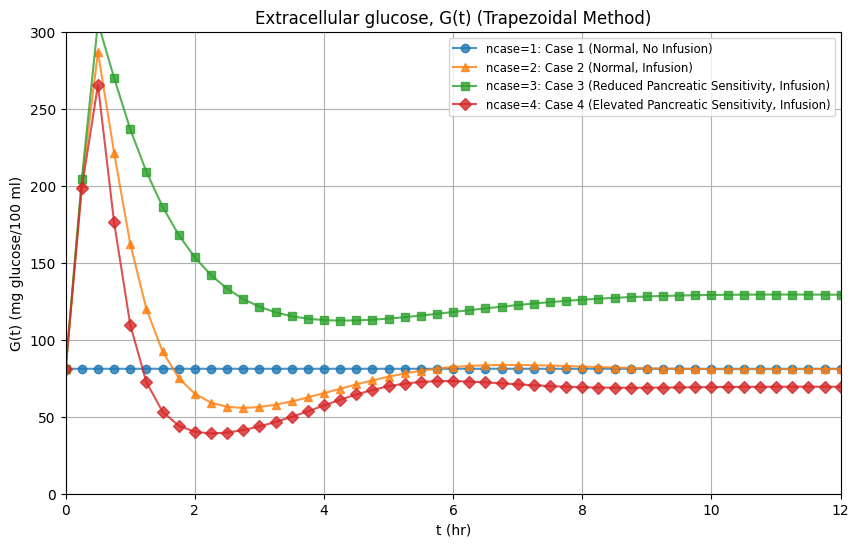

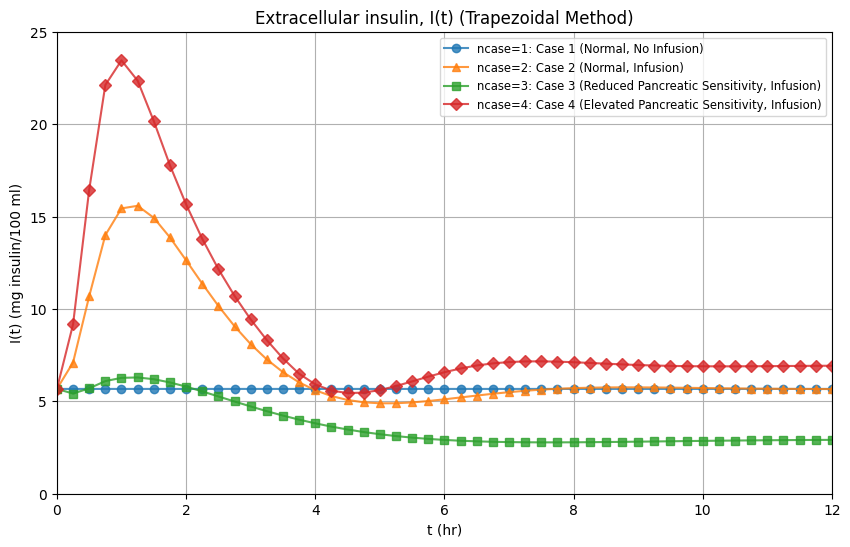

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# --- Global variable to count ODE function calls ---
ode_call_count = 0

# --------------------------------------------------------------------------
# ODE routine: glucose_insulin_ode
# This function defines the system of differential equations (dG/dt and dI/dt).
# It takes time (t), state variables (y), and parameters (params) as input.
# y[0] is Glucose (G), y[1] is Insulin (I)
# --------------------------------------------------------------------------
def glucose_insulin_ode(t, y, params):
    global ode_call_count
    ode_call_count += 1 # Increment call count

    G = y[0]
    I = y[1]

    Cg = params['Cg']
    Ci = params['Ci']
    Q = params['Q']
    Dd = params['Dd']
    Gg = params['Gg']
    Gk = params['Gk']
    Mu = params['Mu']
    G0 = params['G0']
    Aa = params['Aa']
    Bb = params['Bb']
    Gt = params['Gt']

    # Glucose infusion function (In)
    if 0 <= t <= 0.51:
        In = Gt
    else:
        In = 0

    if G < Gk:
        dGdt = (1 / Cg) * (Q + In - (Gg * I * G) - Dd * G)
    else:
        dGdt = (1 / Cg) * (Q + In - (Gg * I * G) - Dd * G - Mu * (G - Gk))

    if G < G0:
        dIdt = (1 / Ci) * (-Aa * I)
    else:
        dIdt = (1 / Ci) * (-Aa * I + Bb * (G - G0))

    return np.array([dGdt, dIdt])

# --------------------------------------------------------------------------
# Function for the implicit equation F(y_next) = 0 for Trapezoidal Method
# The Trapezoidal formula is: y_next = y_current + h/2 * [f(t_current, y_current) + f(t_next, y_next)]
# We want to find the root of: F(y_next) = y_next - y_current - h/2 * f(t_current, y_current) - h/2 * f(t_next, y_next) = 0
# --------------------------------------------------------------------------
def trapezoidal_function(y_next, y_current, t_current, t_next, h, params):
    # f_current is f(t_current, y_current)
    f_current = glucose_insulin_ode(t_current, y_current, params)
    # f_next is f(t_next, y_next)
    f_next = glucose_insulin_ode(t_next, y_next, params)

    # The equation we want to find the root of
    return y_next - y_current - (h / 2) * (f_current + f_next)

# --------------------------------------------------------------------------
# Main program
# --------------------------------------------------------------------------

# Fixed model parameters (from document page 90)
fixed_params = {
    'Ex': 15000,
    'Cg': 150,
    'Ci': 150,
    'Q': 8400,
    'Dd': 24.7,
    'Gg': 13.9,
    'Gk': 250,
    'Mu': 72,
    'G0': 51,
    'Aa': 76
}

# Time parameters for the Trapezoidal integration steps
tout_interval = 0.25 # Output interval
nt_steps_per_interval = 10 # Number of fixed steps per output interval
h = tout_interval / nt_steps_per_interval # Fixed step size

t_span = (0, 12) # Start and end time for simulation
nout = int((t_span[1] - t_span[0]) / tout_interval) + 1 # Number of output points
times_output = np.linspace(t_span[0], t_span[1], nout) # Specific time points for output

# Data storage for plotting later
Gplot = np.zeros((nout, 4))
Iplot = np.zeros((nout, 4))
tplot = np.zeros(nout) # Will be filled with times_output

# Step through four cases
for ncase in range(1, 5):
    global ode_call_count
    ode_call_count = 0 # Reset call count for each case

    current_params = fixed_params.copy()

    if ncase == 1:
        current_params['Bb'] = 14.3
        current_params['Gt'] = 0
    elif ncase == 2:
        current_params['Bb'] = 14.3
        current_params['Gt'] = 80000
    elif ncase == 3:
        current_params['Bb'] = 0.2 * 14.3
        current_params['Gt'] = 80000
    elif ncase == 4:
        current_params['Bb'] = 2.0 * 14.3
        current_params['Gt'] = 80000

    y_current = np.array([81.14, 5.671])
    t_current = t_span[0]

    # --- Print Table Header ---
    print(f"\n ncase = {ncase:2d} \n")
    print(f"{'t':>8} {'In':>8} {'G':>8} {'I':>8}")

    # Loop through each output time point
    for i_out_point in range(nout):
        t_target = times_output[i_out_point]

        # Integrate from t_current up to t_target using fixed steps 'h'
        while t_current < t_target - 1e-9: # Small tolerance to ensure we reach t_target
            step_size_actual = min(h, t_target - t_current)
            t_next = t_current + step_size_actual

            # Initial guess for y_next is y_current
            y_next_guess = y_current

            # Solve the implicit equation using fsolve
            y_next_solved, info, ier, msg = fsolve(
                trapezoidal_function,
                y_next_guess,
                args=(y_current, t_current, t_next, step_size_actual, current_params),
                full_output=True,
                xtol=1e-8,
                maxfev=1000
            )

            if ier != 1:
                # print(f"Warning: fsolve did not converge at t={t_next}. Message: {msg}")
                pass

            y_current = y_next_solved
            t_current = t_next

        # --- Store and Print Output for the current t_target ---

        # Calculate In for printing
        if 0 <= t_target <= 0.51:
            In_print = current_params['Gt']
        else:
            In_print = 0

        # Store solution for plotting
        tplot[i_out_point] = t_target
        Gplot[i_out_point, ncase-1] = y_current[0]
        Iplot[i_out_point, ncase-1] = y_current[1]

        # Print table row (abbreviated output style)
        if i_out_point <= 4 or i_out_point >= (nout - 5):
            print(f"{t_target:>8.2f} {In_print:>8.0f} {y_current[0]:>8.2f} {y_current[1]:>8.3f}")
        elif i_out_point == 5:
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print("Output for t = 1.25 to 10.75 removed")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")
            print(f"{'.':>8} {'.':>8} {'.':>8} {'.':>8}")

    print("\n")
    print(f"ncall = {ode_call_count}\n")
    print("-" * 40)

# --------------------------------------------------------------------------
# Plotting (Figures 2.1 and 2.2 style)
# --------------------------------------------------------------------------

plot_labels = [
    "Case 1 (Normal, No Infusion)",
    "Case 2 (Normal, Infusion)",
    "Case 3 (Reduced Pancreatic Sensitivity, Infusion)",
    "Case 4 (Elevated Pancreatic Sensitivity, Infusion)"
]
mpl_markers = ['o', '^', 's', 'D']

# Plot for Glucose (G)
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(tplot, Gplot[:, i], marker=mpl_markers[i], linestyle='-', linewidth=1.5, alpha=0.8,
             label=f"ncase={i+1}: {plot_labels[i]}")

plt.xlabel("t (hr)")
plt.ylabel("G(t) (mg glucose/100 ml)")
plt.xlim(0, 12)
plt.ylim(0, 300)
plt.title("Extracellular glucose, G(t) (Trapezoidal Method)")
plt.legend(loc="upper right", fontsize='small')
plt.grid(True)
plt.show()

# Plot for Insulin (I)
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(tplot, Iplot[:, i], marker=mpl_markers[i], linestyle='-', linewidth=1.5, alpha=0.8,
             label=f"ncase={i+1}: {plot_labels[i]}")

plt.xlabel("t (hr)")
plt.ylabel("I(t) (mg insulin/100 ml)")
plt.xlim(0, 12)
plt.ylim(0, 25)
plt.title("Extracellular insulin, I(t) (Trapezoidal Method)")
plt.legend(loc="upper right", fontsize='small')
plt.grid(True)
plt.show()

## Fourth Method: **classical 4th-order Runge-Kutta method**(BOOK Method)


--- Case 1 ---
  t (hr)         G(t)         I(t)
    0.00      81.1400       5.6710
    0.25      81.1397       5.6710
    0.50      81.1395       5.6710
    0.75      81.1393       5.6710
    1.00      81.1392       5.6710
    ...        ...         ...
   11.00      81.1392       5.6709
   11.25      81.1392       5.6709
   11.50      81.1392       5.6709
   11.75      81.1392       5.6709
   12.00      81.1392       5.6709

--- Case 2 ---
  t (hr)         G(t)         I(t)
    0.00      81.1400       5.6710
    0.25     201.7137       7.0999
    0.50     286.7184      10.6868
    0.75     220.5671      13.9752
    1.00     161.7433      15.4056
    ...        ...         ...
   11.00      80.8935       5.6811
   11.25      80.9209       5.6746
   11.50      80.9536       5.6697
   11.75      80.9885       5.6661
   12.00      81.0231       5.6637

--- Case 3 ---
  t (hr)         G(t)         I(t)
    0.00      81.1400       5.6710
    0.25     204.2189       5.4200
    0.50     30

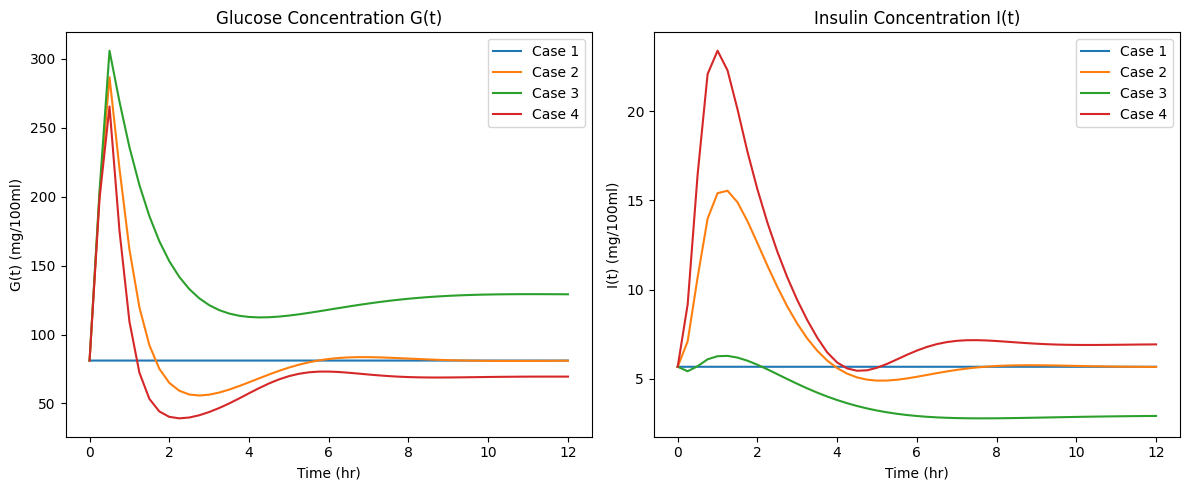

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ---------------------------
# Glucose-Insulin ODE Function
# ---------------------------
def glucose_insulin_ode(t, y, params):
    G, I = y  # Unpack glucose and insulin

    # Glucose infusion function: active only at t <= 0.51 hr
    In = params['Gt'] if 0 <= t <= 0.51 else 0

    # Glucose dynamics
    if G < params['Gk']:
        dGdt = (1 / params['Cg']) * (params['Q'] + In - params['Gg'] * I * G - params['Dd'] * G)
    else:
        dGdt = (1 / params['Cg']) * (params['Q'] + In - params['Gg'] * I * G - params['Dd'] * G - params['Mu'] * (G - params['Gk']))

    # Insulin dynamics
    if G < params['G0']:
        dIdt = (1 / params['Ci']) * (-params['Aa'] * I)
    else:
        dIdt = (1 / params['Ci']) * (-params['Aa'] * I + params['Bb'] * (G - params['G0']))

    return [dGdt, dIdt]

# -----------------------
# Main Simulation Settings
# -----------------------
nout = 49  # number of output points
Gplot = np.zeros((nout, 4))  # 4 cases
Iplot = np.zeros((nout, 4))
tplot = np.zeros(nout)

# Fixed model parameters
fixed_params = {
    'Ex': 15000, 'Cg': 150, 'Ci': 150, 'Q': 8400, 'Dd': 24.7,
    'Gg': 13.9, 'Gk': 250, 'Mu': 72, 'G0': 51, 'Aa': 76
}

# Simulation Cases (as in ISODA)
cases = [
    {'Bb': 14.3, 'Gt': 0},            # Case 1: No glucose infusion
    {'Bb': 14.3, 'Gt': 80000},       # Case 2: Normal Bb, glucose infusion
    {'Bb': 0.2 * 14.3, 'Gt': 80000}, # Case 3: 20% Bb sensitivity
    {'Bb': 2.0 * 14.3, 'Gt': 80000}  # Case 4: 200% Bb sensitivity
]

# --------------------
# Solve for each case
# --------------------
for ncase, case_params in enumerate(cases, 1):
    params = {**fixed_params, **case_params}  # Merge parameters

    y0 = [81.14, 5.671]  # Initial conditions: G0 and I0
    t_span = (0, 12)     # Time from 0 to 12 hr
    t_eval = np.linspace(*t_span, nout)  # 49 points as ISODA

    # Runge-Kutta 4/5 solver (RK45)
    sol = solve_ivp(
        glucose_insulin_ode,
        t_span,
        y0,
        method='RK45',
        t_eval=t_eval,
        args=(params,),
        rtol=1e-6,
        atol=1e-6
    )

    # Store solution
    Gplot[:, ncase - 1] = sol.y[0]  # Glucose
    Iplot[:, ncase - 1] = sol.y[1]  # Insulin
    if ncase == 1:
        tplot = sol.t

    # -------------------------
    # Print ISODA-like table
    # -------------------------
    print(f"\n--- Case {ncase} ---")
    print(f"{'t (hr)':>8} {'G(t)':>12} {'I(t)':>12}")
    for i, t in enumerate(sol.t):
        # Print first 5 points and last 5 points (skip middle like ISODA)
        if i < 5 or i >= nout - 5:
            print(f"{t:8.2f} {sol.y[0, i]:12.4f} {sol.y[1, i]:12.4f}")
        elif i == 5:
            print("    ...        ...         ...")

# --------------------
# Plotting (as ISODA)
# --------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(4):
    plt.plot(tplot, Gplot[:, i], label=f'Case {i + 1}')
plt.title('Glucose Concentration G(t)')
plt.xlabel('Time (hr)')
plt.ylabel('G(t) (mg/100ml)')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(4):
    plt.plot(tplot, Iplot[:, i], label=f'Case {i + 1}')
plt.title('Insulin Concentration I(t)')
plt.xlabel('Time (hr)')
plt.ylabel('I(t) (mg/100ml)')
plt.legend()

plt.tight_layout()
plt.show()


## comparison between the 4 methods and calculate the maximum and the minumu error for each case in each method and extract the execution time for each method


--- Running Simulations for Case 1: Normal, No Infusion ---
--------------------------------------------------

--- Running Simulations for Case 2: Normal, With Infusion ---
--------------------------------------------------

--- Running Simulations for Case 3: Reduced Pancreatic Sensitivity, With Infusion ---
--------------------------------------------------

--- Running Simulations for Case 4: Elevated Pancreatic Sensitivity, With Infusion ---
--------------------------------------------------

--- Method Comparison Table ---
 Case         Method  Execution Time (s)  ODE Calls  Max Rel Error G  Min Rel Error G  Max Rel Error I  Min Rel Error I
    1          LSODA          2.2056e-03         46              NaN              NaN              NaN              NaN
    1          RKF45          3.0126e-02       2880       7.0083e-07       5.8102e-09       8.1442e-07       2.6141e-09
    1    Trapezoidal          4.1190e-02       7144       7.0037e-07       5.8365e-09       8.1399e-07  

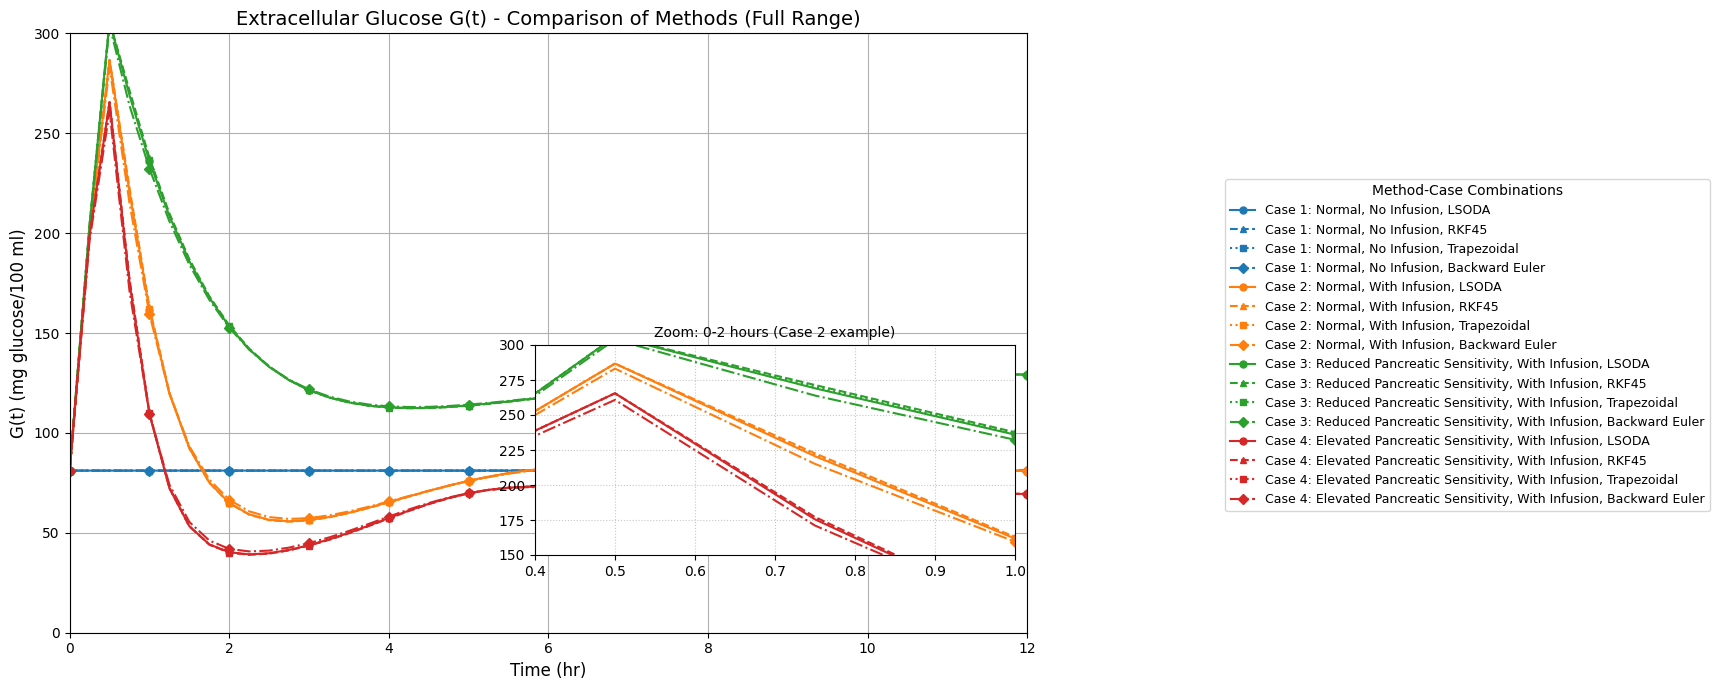

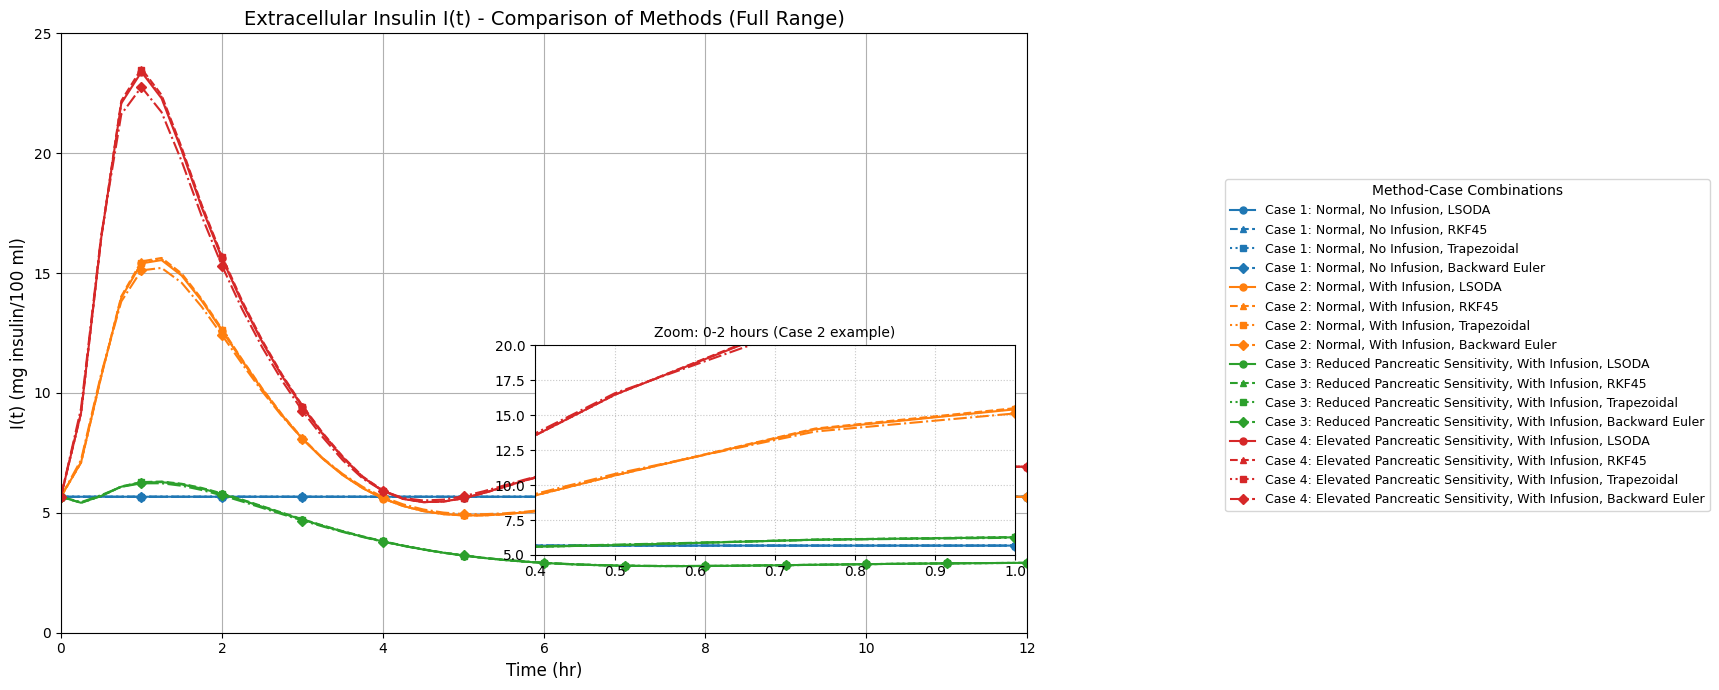

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import time
import pandas as pd # For better table formatting

# Set global matplotlib font properties for better readability
plt.rcParams.update({'font.size': 10, 'lines.markersize': 5})

# --- Global variable to count ODE function calls ---
_ode_call_count = 0

# --------------------------------------------------------------------------
# 1. ODE Routine: glucose_insulin_ode (Common for all methods)
# This function defines the system of differential equations (dG/dt and dI/dt).
# It takes time (t), state variables (y), and parameters (params) as input.
# y[0] is Glucose (G), y[1] is Insulin (I)
# --------------------------------------------------------------------------
def glucose_insulin_ode(t, y, params):
    global _ode_call_count
    _ode_call_count += 1 # Increment call count for every derivative evaluation

    G = y[0]
    I = y[1] # Corrected typo: was I = y[1] = I

    Cg = params['Cg']
    Ci = params['Ci']
    Q = params['Q']
    Dd = params['Dd']
    Gg = params['Gg']
    Gk = params['Gk']
    Mu = params['Mu']
    G0 = params['G0']
    Aa = params['Aa']
    Bb = params['Bb']
    Gt = params['Gt']

    # Glucose infusion function (In)
    if 0 <= t <= 0.51: # Using 0.51 to avoid floating point issues with t=0.5
        In = Gt
    else:
        In = 0

    # Glucose equations (Eqs. 2.1b and 2.1c)
    if G < Gk:
        dGdt = (1 / Cg) * (Q + In - (Gg * I * G) - Dd * G)
    else: # G >= Gk
        dGdt = (1 / Cg) * (Q + In - (Gg * I * G) - Dd * G - Mu * (G - Gk))

    # Insulin equations (Eqs. 2.2b and 2.2c)
    if G < G0:
        dIdt = (1 / Ci) * (-Aa * I)
    else: # G >= G0
        dIdt = (1 / Ci) * (-Aa * I + Bb * (G - G0))

    return np.array([dGdt, dIdt])

# --------------------------------------------------------------------------
# 2. Solver Implementations
# Each solver function will return (t_eval, G_sol, I_sol, call_count)
# --------------------------------------------------------------------------

# a. LSODA Solver (using scipy.integrate.solve_ivp)
def solve_lsoda(y0, t_span, t_eval, params, **kwargs): # kwargs for consistency
    global _ode_call_count
    _ode_call_count = 0
    sol = solve_ivp(
        fun=glucose_insulin_ode,
        t_span=t_span,
        y0=y0,
        method='LSODA',
        t_eval=t_eval,
        args=(params,),
        rtol=1e-6,
        atol=1e-6
    )
    return sol.t, sol.y[0], sol.y[1], _ode_call_count

# b. RKF45 Solver (custom implementation based on R code)
def solve_rkf45(y0, t_span, t_eval, params, h_inner):
    global _ode_call_count
    _ode_call_count = 0
    _ee = np.array([0.0, 0.0]) # Error estimate variable, updated but not used for step control in this fixed-step version

    def rkf45_single_step(y_current, t_current, h_step, params_rkf):
        # f_rk_call is a wrapper to call the global ode function but pass rkf params
        def f_rk_call(t_val, y_val):
            return glucose_insulin_ode(t_val, y_val, params_rkf)

        k1 = f_rk_call(t_current, y_current) * h_step
        k2 = f_rk_call(t_current + 0.25 * h_step, y_current + 0.25 * k1) * h_step
        k3 = f_rk_call(t_current + (3/8) * h_step, y_current + (3/32) * k1 + (9/32) * k2) * h_step
        k4 = f_rk_call(t_current + (12/13) * h_step, y_current + (1932/2197) * k1 - (7200/2197) * k2 + (7296/2197) * k3) * h_step
        k5 = f_rk_call(t_current + h_step, y_current + (439/216) * k1 - 8 * k2 + (3680/513) * k3 - (845/4104) * k4) * h_step
        k6 = f_rk_call(t_current + 0.5 * h_step, y_current - (8/27) * k1 + 2 * k2 - (3544/2565) * k3 + (1859/4104) * k4 - (11/40) * k5) * h_step

        y_fifth_order = y_current + (16/135) * k1 + (6656/12825) * k3 + (28561/56430) * k4 - (9/50) * k5 + (2/55) * k6
        y_fourth_order = y_current + (25/216) * k1 + (1408/2565) * k3 + (2197/4104) * k4 - (1/5) * k5
        _ee[:] = y_fifth_order - y_fourth_order
        return y_fifth_order

    G_sol = []
    I_sol = []

    y_current = np.array(y0)
    t_current = t_span[0]

    G_sol.append(y_current[0])
    I_sol.append(y_current[1])

    for i in range(1, len(t_eval)):
        t_target = t_eval[i]
        while t_current < t_target - 1e-12: # Use a small tolerance for floating point comparisons
            step_size_actual = min(h_inner, t_target - t_current)
            if step_size_actual <= 1e-12: break # Avoid tiny or zero step sizes
            y_current = rkf45_single_step(y_current, t_current, step_size_actual, params)
            t_current += step_size_actual
        G_sol.append(y_current[0])
        I_sol.append(y_current[1])

    return np.array(t_eval), np.array(G_sol), np.array(I_sol), _ode_call_count

# c. Trapezoidal Method Solver (Crank-Nicolson)
def solve_trapezoidal(y0, t_span, t_eval, params, h_inner):
    global _ode_call_count
    _ode_call_count = 0

    def trapezoidal_function(y_next_guess, y_current_step, t_current_step, t_next_step, h_step, params_trap):
        f_current = glucose_insulin_ode(t_current_step, y_current_step, params_trap)
        f_next = glucose_insulin_ode(t_next_step, y_next_guess, params_trap)
        return y_next_guess - y_current_step - (h_step / 2) * (f_current + f_next)

    G_sol = []
    I_sol = []

    y_current = np.array(y0)
    t_current = t_span[0]

    G_sol.append(y_current[0])
    I_sol.append(y_current[1])

    for i in range(1, len(t_eval)):
        t_target = t_eval[i]
        while t_current < t_target - 1e-12:
            step_size_actual = min(h_inner, t_target - t_current)
            if step_size_actual <= 1e-12: break

            y_next_guess = y_current
            y_next_solved, info, ier, msg = fsolve(
                trapezoidal_function,
                y_next_guess,
                args=(y_current, t_current, t_current + step_size_actual, step_size_actual, params),
                full_output=True, xtol=1e-8, maxfev=1000
            )
            if ier != 1: pass # Suppress convergence warnings
            y_current = y_next_solved
            t_current += step_size_actual
        G_sol.append(y_current[0])
        I_sol.append(y_current[1])

    return np.array(t_eval), np.array(G_sol), np.array(I_sol), _ode_call_count

# d. Backward Euler Solver
def solve_backward_euler(y0, t_span, t_eval, params, h_inner):
    global _ode_call_count
    _ode_call_count = 0

    def implicit_euler_function(y_next_guess, y_current_step, t_next_step, h_step, params_be):
        f_next = glucose_insulin_ode(t_next_step, y_next_guess, params_be)
        return y_next_guess - y_current_step - h_step * f_next

    G_sol = []
    I_sol = []

    y_current = np.array(y0)
    t_current = t_span[0]

    G_sol.append(y_current[0])
    I_sol.append(y_current[1])

    for i in range(1, len(t_eval)):
        t_target = t_eval[i]
        while t_current < t_target - 1e-12:
            step_size_actual = min(h_inner, t_target - t_current)
            if step_size_actual <= 1e-12: break

            y_next_guess = y_current
            y_next_solved, info, ier, msg = fsolve(
                implicit_euler_function,
                y_next_guess,
                args=(y_current, t_current + step_size_actual, step_size_actual, params),
                full_output=True, xtol=1e-8, maxfev=1000
            )
            if ier != 1: pass # Suppress convergence warnings
            y_current = y_next_solved
            t_current += step_size_actual
        G_sol.append(y_current[0])
        I_sol.append(y_current[1])

    return np.array(t_eval), np.array(G_sol), np.array(I_sol), _ode_call_count


# --------------------------------------------------------------------------
# 3. Main Simulation and Comparison Logic
# --------------------------------------------------------------------------

# General Simulation Settings
nout = 49
t_span = (0, 12)
times_output = np.linspace(t_span[0], t_span[1], nout)
yini = [81.14, 5.671]

# Fixed model parameters
fixed_params = {
    'Ex': 15000, 'Cg': 150, 'Ci': 150,
    'Q': 8400, 'Dd': 24.7, 'Gg': 13.9,
    'Gk': 250, 'Mu': 72, 'G0': 51, 'Aa': 76
}

# Simulation Cases
cases_setup = [
    {'Bb': 14.3, 'Gt': 0, 'label': 'Case 1: Normal, No Infusion'},
    {'Bb': 14.3, 'Gt': 80000, 'label': 'Case 2: Normal, With Infusion'},
    {'Bb': 0.2 * 14.3, 'Gt': 80000, 'label': 'Case 3: Reduced Pancreatic Sensitivity, With Infusion'},
    {'Bb': 2.0 * 14.3, 'Gt': 80000, 'label': 'Case 4: Elevated Pancreatic Sensitivity, With Infusion'}
]

# Methods to compare (and their inner step size for fixed-step methods)
methods_config = {
    "LSODA": {"solver_func": solve_lsoda, "h_inner": None},
    "RKF45": {"solver_func": solve_rkf45, "h_inner": 0.025},
    "Trapezoidal": {"solver_func": solve_trapezoidal, "h_inner": 0.025},
    "Backward Euler": {"solver_func": solve_backward_euler, "h_inner": 0.025}
}

# Data structures to store all results and metrics
all_results = {}
comparison_metrics = []

# Run simulations for all cases and methods
for ncase_idx, case_config in enumerate(cases_setup):
    ncase = ncase_idx + 1
    print(f"\n--- Running Simulations for {case_config['label']} ---")

    current_params = fixed_params.copy()
    current_params.update(case_config)

    all_results[ncase] = {}

    lsoda_t, lsoda_G, lsoda_I = (None, None, None) # Reference for error calculation

    for method_name, config in methods_config.items():
        solver_func = config["solver_func"]
        h_inner = config["h_inner"]

        start_time = time.time()

        t_sol, G_sol, I_sol, ode_calls = solver_func(yini, t_span, times_output, current_params, h_inner=h_inner)

        end_time = time.time()
        exec_time = end_time - start_time

        all_results[ncase][method_name] = {
            't': t_sol, 'G': G_sol, 'I': I_sol
        }

        if method_name == "LSODA":
            lsoda_t, lsoda_G, lsoda_I = t_sol, G_sol, I_sol
            comparison_metrics.append({
                'Case': ncase, 'Method': method_name,
                'Execution Time (s)': exec_time,
                'ODE Calls': ode_calls,
                'Max Rel Error G': np.nan, 'Min Rel Error G': np.nan,
                'Max Rel Error I': np.nan, 'Min Rel Error I': np.nan
            })
        else:
            eps = 1e-12

            # Calculate Relative Error against LSODA (reference)
            # Filter out points where LSODA reference is zero or near zero to avoid division by zero/large errors
            # Also exclude initial point (t=0) as it's the exact IC and relative error is often ill-defined.
            # Using absolute values for filtering to ensure correct behavior near zero.
            valid_indices = (np.abs(lsoda_G) > eps) & (np.abs(lsoda_I) > eps) & (times_output > 0)

            rel_err_G = np.abs((G_sol[valid_indices] - lsoda_G[valid_indices]) / lsoda_G[valid_indices])
            rel_err_I = np.abs((I_sol[valid_indices] - lsoda_I[valid_indices]) / lsoda_I[valid_indices])

            # Ensure no NaNs or Infs from calculation
            rel_err_G = rel_err_G[np.isfinite(rel_err_G)]
            rel_err_I = rel_err_I[np.isfinite(rel_err_I)]

            max_rel_G = np.max(rel_err_G) if rel_err_G.size > 0 else np.nan
            min_rel_G = np.min(rel_err_G) if rel_err_G.size > 0 else np.nan
            max_rel_I = np.max(rel_err_I) if rel_err_I.size > 0 else np.nan
            min_rel_I = np.min(rel_err_I) if rel_err_I.size > 0 else np.nan

            comparison_metrics.append({
                'Case': ncase, 'Method': method_name,
                'Execution Time (s)': exec_time,
                'ODE Calls': ode_calls,
                'Max Rel Error G': max_rel_G, 'Min Rel Error G': min_rel_G,
                'Max Rel Error I': max_rel_I, 'Min Rel Error I': min_rel_I
            })
    print("-" * 50)

# Convert comparison metrics to DataFrame for pretty printing
comparison_df = pd.DataFrame(comparison_metrics)

# Set display options for better printing of floats and columns
pd.set_option('display.float_format', '{:.4e}'.format)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

print("\n--- Method Comparison Table ---")
print(comparison_df.to_string(index=False))
print("\n*Note: Relative errors are calculated against LSODA solution. N/A for LSODA as it is the reference.")
print("Errors are filtered to exclude the initial time point and instances where the LSODA reference is zero/near zero.")


# --------------------------------------------------------------------------
# 4. Combined Plotting with Zoomed Insets for Clearer Differences
# --------------------------------------------------------------------------

# Define consistent styles for each method
# Each method gets a unique linestyle and marker for easy identification across cases
method_plotting_styles = {
    "LSODA": {'linestyle': '-', 'marker': 'o',  'markevery': 4, 'linewidth': 1.5},
    "RKF45": {'linestyle': '--', 'marker': '^', 'markevery': 4, 'linewidth': 1.5},
    "Trapezoidal": {'linestyle': ':', 'marker': 's', 'markevery': 4, 'linewidth': 1.5},
    "Backward Euler": {'linestyle': '-.', 'marker': 'D',  'markevery': 4, 'linewidth': 1.5}
}

# Define distinct colors for each case
case_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red'
}

# --- Plot for Glucose (G) ---
fig_G, ax_G = plt.subplots(figsize=(12, 7))

# Plot all 16 lines on the main axis
for ncase in all_results.keys():
    case_label = cases_setup[ncase-1]['label']
    for method_name, style in method_plotting_styles.items():
        data = all_results[ncase][method_name]
        # Combine case and method into a single label for the legend
        label_text = f"{case_label}, {method_name}"
        ax_G.plot(data['t'], data['G'],
                  color=case_colors[ncase], **style, label=label_text)

ax_G.set_xlabel("Time (hr)", fontsize=12)
ax_G.set_ylabel("G(t) (mg glucose/100 ml)", fontsize=12)
ax_G.set_xlim(0, 12)
ax_G.set_ylim(0, 300)
ax_G.set_title("Extracellular Glucose G(t) - Comparison of Methods (Full Range)", fontsize=14)
ax_G.grid(True)

# Create a custom legend for all lines, placed outside the plot for readability
handles, labels = ax_G.get_legend_handles_labels()
fig_G.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, fontsize=9, title="Method-Case Combinations")
plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout to make space for the legend

# --- Add an Inset Subplot for a zoomed-in view of G(t) ---
# This helps to clearly see point-to-point differences and small variations
ax_G_inset = fig_G.add_axes([0.45, 0.2, 0.4, 0.3]) # [left, bottom, width, height] in figure coordinates
for ncase in all_results.keys():
    for method_name, style in method_plotting_styles.items():
        data = all_results[ncase][method_name]
        ax_G_inset.plot(data['t'], data['G'], color=case_colors[ncase], **style)

ax_G_inset.set_title('Zoom: 0-2 hours (Case 2 example)', fontsize=10) # Focused title
ax_G_inset.set_xlim(0.4, 1.0) # More tightly zoomed range for a specific transient
ax_G_inset.set_ylim(150, 300) # Adjust Y-limit for better visibility in zoomed area
ax_G_inset.grid(True, linestyle=':', alpha=0.7)
plt.show()

# --- Plot for Insulin (I) ---
fig_I, ax_I = plt.subplots(figsize=(12, 7))

# Plot all 16 lines on the main axis
for ncase in all_results.keys():
    case_label = cases_setup[ncase-1]['label']
    for method_name, style in method_plotting_styles.items():
        data = all_results[ncase][method_name]
        label_text = f"{case_label}, {method_name}"
        ax_I.plot(data['t'], data['I'],
                  color=case_colors[ncase], **style, label=label_text)

ax_I.set_xlabel("Time (hr)", fontsize=12)
ax_I.set_ylabel("I(t) (mg insulin/100 ml)", fontsize=12)
ax_I.set_xlim(0, 12)
ax_I.set_ylim(0, 25)
ax_I.set_title("Extracellular Insulin I(t) - Comparison of Methods (Full Range)", fontsize=14)
ax_I.grid(True)

# Create a custom legend for all lines, placed outside the plot for readability
handles, labels = ax_I.get_legend_handles_labels()
fig_I.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, fontsize=9, title="Method-Case Combinations")
plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout

# --- Add an Inset Subplot for a zoomed-in view of I(t) ---
ax_I_inset = fig_I.add_axes([0.45, 0.2, 0.4, 0.3]) # [left, bottom, width, height] in figure coordinates
for ncase in all_results.keys():
    for method_name, style in method_plotting_styles.items():
        data = all_results[ncase][method_name]
        ax_I_inset.plot(data['t'], data['I'], color=case_colors[ncase], **style)

ax_I_inset.set_title('Zoom: 0-2 hours (Case 2 example)', fontsize=10) # Focused title
ax_I_inset.set_xlim(0.4, 1.0) # More tightly zoomed range
ax_I_inset.set_ylim(5, 20) # Adjust Y-limit for better visibility
ax_I_inset.grid(True, linestyle=':', alpha=0.7)
plt.show()